In [29]:
# Importing all required packages
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from keras.layers import Dense,LSTM,Dropout,Flatten
from keras import Sequential
from keras import backend as K
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Gather the Apple data
tick = "AAPL"
df = yf.download(tick)
df.index = pd.to_datetime(df.index)

#Drop unnecessary columns, and filter data
df = df[df.index >= '2018-01-01']

# Add returns column
df['Return'] = (df['Adj Close']-df['Open'])/df['Open']

#Create copy of dataset for later use
stock_data = df.copy()
df.head(5)

[*********************100%%**********************]  1 of 1 completed
C:\Users\Matt\AppData\Local\Temp\ipykernel_2800\2809542692.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.670975,102223600,-0.043936
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.663898,118071600,-0.057233
2018-01-04,43.134998,43.367500,43.020000,43.257500,40.852779,89738400,-0.052909
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.317905,94640000,-0.047096
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.164436,82271200,-0.055591


In [16]:
# Calculate yearly return of Apple
yearly_returns = []

for year, group in df.groupby(df.index.year):
    start_price = group.iloc[0]['Open']
    end_price = group.iloc[-1]['Close']
    yearly_return = (end_price - start_price) / start_price * 100
    yearly_return = round(yearly_return, 2)
    yearly_returns.append((year, yearly_return))

yearly_returns_df = pd.DataFrame(yearly_returns, columns=['Year', 'Yearly_Return'])

print(yearly_returns_df)


   Year  Yearly_Return
0  2018          -7.30
1  2019          89.59
2  2020          79.17
3  2021          32.99
4  2022         -26.94
5  2023          47.78
6  2024          -7.73


In [17]:
# Plot the yearly return
bar_trace = go.Bar(x=yearly_returns_df['Year'], y=yearly_returns_df['Yearly_Return'],
                   marker=dict(color='skyblue'))

layout = go.Layout(title='Yearly Returns of Apple Stock (2018-2024)',
                   xaxis=dict(title='Year'),
                   yaxis=dict(title='Yearly Return (%)'))

fig = go.Figure(data=[bar_trace], layout=layout)
fig.show()

In [18]:
# Create both 50 and 200 day moving average
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

# Group into monthly for the candlesticks
apple_data_monthly = df.resample('M').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

# Create trace for the candlesticks
candlestick = go.Candlestick(x=apple_data_monthly.index,
                open=apple_data_monthly['Open'],
                high=apple_data_monthly['High'],
                low=apple_data_monthly['Low'],
                close=apple_data_monthly['Close'],
                name='Candlestick')

#Create trace for moving averages, intially set to not be visible
ma_50 = go.Scatter(x=df.index, y=df['MA50'], mode='lines', name='50-Day MA', line=dict(color='grey'), visible = False)
ma_200 = go.Scatter(x=df.index, y=df['MA200'], mode='lines', name='200-Day MA', line=dict(color='black'), visible = False)

# Create buttons to toggle moving averages
button_50 = dict(label='50-Day MA', method='update', args=[{'visible': [True, True, False]}, {'title': 'Apple Inc. (AAPL) - 50-Day MA'}])
button_200 = dict(label='200-Day MA', method='update', args=[{'visible': [True, False, True]}, {'title': 'Apple Inc. (AAPL) - 200-Day MA'}])
button_both = dict(label='Both', method='update', args=[{'visible': [True, True, True]}, {'title': 'Apple Inc. (AAPL)'}])
button_none = dict(label='None', method='update', args=[{'visible': [True, False, False, False]}, {'title': 'Apple Inc. (AAPL)'}])

# Creating button menu
updatemenus = list([
    dict(active=3,
         buttons=[button_50, button_200, button_both, button_none],
         x=1.0,
         y=1.3,
         xanchor='right',
         yanchor='top',
         pad=dict(t=0, r=10),
         showactive=True)
])


# Updating layout of figure
layout = dict(title='Apple Inc. (AAPL)',
              xaxis_title='Date',
              yaxis_title='Stock Price ($)',
              updatemenus=updatemenus)

# Create and display figure
fig = go.Figure(data=[candlestick, ma_50, ma_200], layout=layout)
fig.show()

C:\Users\Matt\AppData\Local\Temp\ipykernel_2800\183483669.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Matt\AppData\Local\Temp\ipykernel_2800\183483669.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



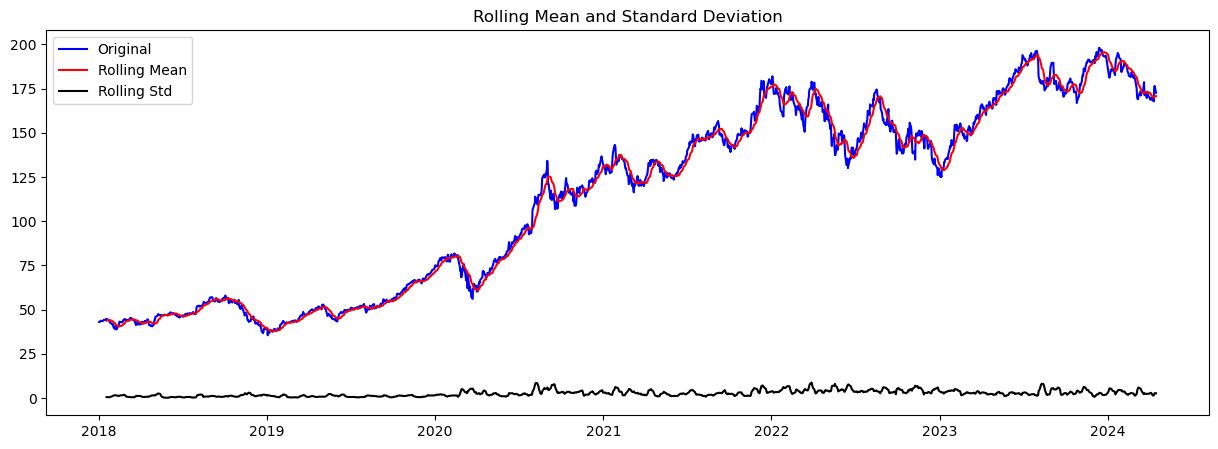

Results of dickey fuller test
Test Statistics                  -1.012432
p-value                           0.748703
No. of lags used                  0.000000
Number of observations used    1580.000000
dtype: float64


In [19]:
#Test data for staionarity
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.figure(figsize=(15,5))
    plt.plot(timeseries,color='blue',label='Original')
    plt.plot(rolmean,color='red',label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    print(output)

test_stationarity(df['Close'])    

In [20]:
# Making the data stationary
df['Stock Differencing']=df['Close']-df['Close'].shift(1)
adft = adfuller(df['Stock Differencing'].dropna(),autolag='AIC')
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
print(output)

Test Statistics                 -40.947941
p-value                           0.000000
No. of lags used                  0.000000
Number of observations used    1579.000000
dtype: float64


C:\Users\Matt\AppData\Local\Temp\ipykernel_2800\4189365159.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
# Create training and testing sets for models
stock_data.index = pd.to_datetime(stock_data.index)
df_train = stock_data[stock_data.index < '2023-02-02']
df_valid = stock_data[stock_data.index >= '2023-02-02']
lstm_train = df[df.index < '2023-02-02']
lstm_valid = df[df.index >= '2023-02-02']
train = df_train['Close'].values
test = df_valid['Close'].values
train_lstm = lstm_train['Close'].values
test_lstm = lstm_valid['Close'].values
print(df_train.shape)
print(df_valid.shape)

(1280, 7)
(301, 7)


In [22]:
# Find optimal p,d,q for ARIMA model
model = auto_arima(train, start_p=0, start_q=0, test='adf', max_p=3, max_q=3,
                   m=1, d=None, seasonal=False,
                   start_P=0, D=0,
                   trace=True, error_action='ignore',
                   suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5678.364, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5676.017, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5675.738, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5678.019, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5676.483, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5676.617, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5678.378, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5675.620, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5676.521, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5676.615, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5675.872, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5678.420, Time=0.31 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.546 seconds


In [23]:
# After finding the optimal p,d,q values, fit and create the model.

history = [x for x in train]
predictions = list()

for t in range(len(df_valid)):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=145.357025, expected=150.820007
predicted=150.496348, expected=154.500000
predicted=154.278637, expected=151.729996
predicted=151.875844, expected=154.649994
predicted=154.487984, expected=151.919998
predicted=152.072792, expected=150.869995
predicted=150.941012, expected=151.009995
predicted=151.005918, expected=153.850006
predicted=153.681869, expected=153.199997
predicted=153.228553, expected=155.330002
predicted=155.205090, expected=153.710007
predicted=153.799580, expected=152.550003
predicted=152.624553, expected=148.479996
predicted=148.723499, expected=148.910004
predicted=148.899051, expected=149.399994
predicted=149.370486, expected=146.710007
predicted=146.867291, expected=147.919998
predicted=147.857362, expected=147.410004
predicted=147.436680, expected=145.309998
predicted=145.436543, expected=145.910004
predicted=145.881771, expected=151.029999
predicted=150.724313, expected=153.830002
predicted=153.654521, expected=151.600006
predicted=151.718721, expected=152

In [24]:
fig = go.Figure()

fig.update_layout(xaxis_title="Date", yaxis_title="Stock Price ($)", title = "Actual vs. Forecasted Closing Price of Apple (ARIMA)")
fig.add_trace(go.Scatter(x=df_train.index,y=df_train.Close,name='Training Data'))
fig.add_trace(go.Scatter(x=df_valid.index,y=df_valid.Close,name='Testing Data'))
fig.add_trace(go.Scatter(x=df_valid.index,y=predictions,name='Forecasted Data'))

fig.show()

In [25]:
# Getting the Root Mean Squared Error of the ARIMA model
rmse_arima = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse_arima)

Test RMSE: 2.240


In [26]:
# Calculating prediction inside threshold of 1%
threshold = 1

actual_prices = df_valid['Close']
percentage_changes = ((predictions - actual_prices) / actual_prices) * 100
correct_predictions = np.sum(np.abs(percentage_changes) <= threshold)

rate_ARIMA = (correct_predictions / len(actual_prices)) * 100

print("Hit Rate: %.2f%%" % rate_ARIMA)


Hit Rate: 65.12%


In [27]:
# Pre-process data for LSTM model
# Scaling and reshaping data
scaler = MinMaxScaler(feature_range=(0,1))
training_values = np.reshape(train_lstm,(len(train_lstm),1))
training_values = scaler.fit_transform(training_values)

# Assigning training values to the training data
x_train = training_values[0:len(training_values)-1]
y_train = training_values[1:len(training_values)]
x_train = np.reshape(x_train,(len(x_train),1,1))

In [28]:
# Creating, compiling, training the model
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train,y_train,epochs=5,batch_size=8)



Epoch 1/5

160/160 [==============================] - 6s 4ms/step - loss: 0.0440
Epoch 2/5
160/160 [==============================] - 1s 4ms/step - loss: 4.1534e-04
Epoch 3/5
160/160 [==============================] - 0s 3ms/step - loss: 3.8576e-04
Epoch 4/5
160/160 [==============================] - 0s 2ms/step - loss: 3.3200e-04
Epoch 5/5
160/160 [==============================] - 0s 2ms/step - loss: 2.8150e-04


In [29]:
# assign test and predicted values + reshaping + converting back from scaler
test_values = np.reshape(test_lstm, (len(test_lstm), 1))
test_values = scaler.transform(test_values)
test_values = np.reshape(test_values, (len(test_values), 1, 1))
predicted_price = model.predict(test_values)
predicted_price = scaler.inverse_transform(predicted_price)
predicted_price = np.squeeze(predicted_price)


10/10 [==============================] - 1s 2ms/step


In [30]:
# Getting the Root Mean Squared Error of the LSTM model
rmse_lstm = math.sqrt(mean_squared_error(test, predicted_price))
print('Test MSE: %.3f' % rmse_lstm)

Test MSE: 3.213


In [31]:
fig = go.Figure()
fig.update_layout(xaxis_title="Date", yaxis_title="Stock Price ($)", title = "Actual vs. Forecasted Closing Price of Apple (LSTM)")
fig.add_trace(go.Scatter(x=df_train.index,y=df_train.Close,name='Training Data'))
fig.add_trace(go.Scatter(x=df_valid.index,y=df_valid.Close,name='Testing Data'))
fig.add_trace(go.Scatter(x=df_valid.index,y=predicted_price,name='Forecasted Data'))

fig.show()

In [32]:
# Calculating prediction inside threshold of 1%
threshold = 1

actual_prices = df_valid['Close']
percentage_changes = ((predicted_price - actual_prices) / actual_prices) * 100
correct_predictions = np.sum(np.abs(percentage_changes) <= threshold)

rate_LSTM = (correct_predictions / len(actual_prices)) * 100

print("Hit Rate: %.2f%%" % rate_LSTM)


Hit Rate: 0.00%


In [33]:
# Display the results of the models
model_table = {'ARIMA': [rmse_arima, rate_ARIMA],
        'LSTM': [rmse_lstm, rate_LSTM]}

comparison = pd.DataFrame(model_table, index=['RMSE', 'Rate'])

print(comparison)

          ARIMA      LSTM
RMSE   2.240399  3.213397
Rate  65.116279  0.000000


In [34]:
# Creating two trading strategies to compare

def buy_and_hold(initial_balance, closing_prices):
    initial_price = closing_prices[0]  # Initial closing price
    final_price = closing_prices[-1]   # Final closing price
    shares_bought = initial_balance / initial_price  # Calculate the number of shares bought
    final_balance = shares_bought * final_price  # Calculate the ending balance after selling at the final price
    return final_balance


def arima_trading_strategy(initial_balance, actual_prices, arima_predictions):
    balance = initial_balance
    position_open = False
    buy_price = None
    shares = 0

    for i in range(1, len(arima_predictions)):
        if arima_predictions[i] > arima_predictions[i - 1] and not position_open:
            buy_price = actual_prices[i-1]
            shares = balance / buy_price
            balance -= shares * buy_price
            position_open = True
        elif arima_predictions[i] < arima_predictions[i - 1] and position_open:
            sell_price = actual_prices[i-1]
            balance += shares * sell_price
            shares = 0
            position_open = False

    if position_open:  # Close position if still open at the end
        balance += shares * actual_prices[-1]

    return balance





In [35]:
# Adding values to parameters
initial_balance = 10000
actual_prices = df_valid['Close'].values
initial_price = actual_prices[0]
arima_predictions = predictions

# Call functions and display output
ending_balance_arima = arima_trading_strategy(initial_balance, arima_predictions, actual_prices)
print("Ending Balance for ARIMA Strategy: ${:.2f}".format(round(ending_balance_arima, 2)))
ending_balance_bah = buy_and_hold(initial_balance, actual_prices)
print("Ending Balance for Buy and Hold Strategy: ${:.2f}".format(round(ending_balance_bah, 2)))



Ending Balance for ARIMA Strategy: $11690.72
Ending Balance for Buy and Hold Strategy: $11450.07


In [19]:
def create_dataset(ticker):
    # Gather data, preprocess, and add return column
    df = yf.download(ticker)
    df.index = pd.to_datetime(df.index)
    df = df[df.index >= '2018-01-01']
    df['Return'] = (df['Adj Close'] - df['Open']) / df['Open']
    return df


In [20]:
def yearly_returns(df, ticker):
    yearly_returns = []

    # Group data and calculate yearly return
    for year, group in df.groupby(df.index.year):
        start_price = group.iloc[0]['Open']
        end_price = group.iloc[-1]['Close']
        yearly_return = (end_price - start_price) / start_price * 100
        yearly_return = round(yearly_return, 2)
        yearly_returns.append((year, yearly_return))

    # Plot yearly returns
    yearly_returns_df = pd.DataFrame(yearly_returns, columns=['Year', 'Yearly_Return'])
    bar_trace = go.Bar(x=yearly_returns_df['Year'], y=yearly_returns_df['Yearly_Return'],
                       marker=dict(color='skyblue'))

    layout = go.Layout(title=f'Yearly Returns of {ticker} (2018-2024)',
                       xaxis=dict(title='Year'),
                       yaxis=dict(title='Yearly Return (%)'))

    fig = go.Figure(data=[bar_trace], layout=layout)
    fig.show()


In [21]:
def candlestick_chart(df, ticker):
    # Create both 50 and 200 day moving average
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['MA200'] = df['Close'].rolling(window=200).mean()

    # Group into monthly for the candlesticks
    monthly_data = df.resample('M').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })

    # Create trace for the candlesticks
    candlestick = go.Candlestick(x=monthly_data.index,
                    open=monthly_data['Open'],
                    high=monthly_data['High'],
                    low=monthly_data['Low'],
                    close=monthly_data['Close'],
                    name='Candlestick')

    #Create trace for moving averages, intially set to not be visible
    ma_50 = go.Scatter(x=df.index, y=df['MA50'], mode='lines', name='50-Day MA', line=dict(color='grey'), visible = False)
    ma_200 = go.Scatter(x=df.index, y=df['MA200'], mode='lines', name='200-Day MA', line=dict(color='black'), visible = False)

    # Create buttons to toggle moving averages
    button_50 = dict(label='50-Day MA', method='update', args=[{'visible': [True, True, False]}, {'title': f'({ticker}) - 50-Day MA'}])
    button_200 = dict(label='200-Day MA', method='update', args=[{'visible': [True, False, True]}, {'title': f'({ticker}) - 200-Day MA'}])
    button_both = dict(label='Both', method='update', args=[{'visible': [True, True, True]}, {'title': f'({ticker})'}])
    button_none = dict(label='None', method='update', args=[{'visible': [True, False, False, False]}, {'title': f'({ticker})'}])

    # Creating button menu
    updatemenus = list([
        dict(active=3,
            buttons=[button_50, button_200, button_both, button_none],
            x=1.0,
            y=1.3,
            xanchor='right',
            yanchor='top',
            pad=dict(t=0, r=10),
            showactive=True)
    ])


    # Updating layout of figure
    layout = dict(title=f'({ticker})',
                xaxis_title='Date',
                yaxis_title='Stock Price ($)',
                updatemenus=updatemenus)

    # Create and display figure
    fig = go.Figure(data=[candlestick, ma_50, ma_200], layout=layout)
    fig.show()

[*********************100%%**********************]  1 of 1 completed
C:\Users\Matt\AppData\Local\Temp\ipykernel_19288\1235893071.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Matt\AppData\Local\Temp\ipykernel_19288\3919193385.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Matt\AppData\Local\Temp\ipykernel_19288\3919193385.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

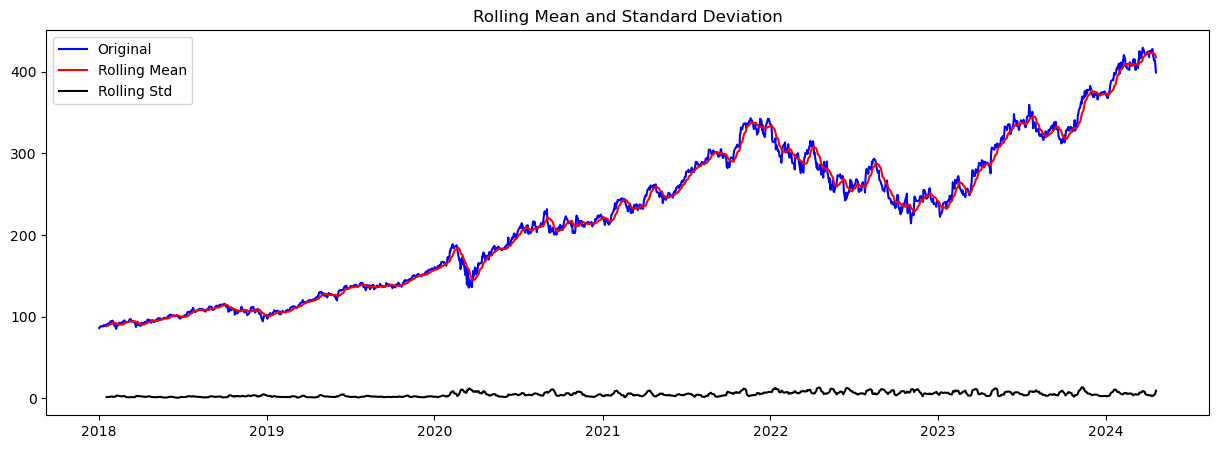

Results of dickey fuller test
Test Statistics                  -0.275405
p-value                           0.928916
No. of lags used                  9.000000
Number of observations used    1575.000000
dtype: float64


False

In [23]:
# Test if the data is stationary and visualize it
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.figure(figsize=(15,5))
    plt.plot(timeseries,color='blue',label='Original')
    plt.plot(rolmean,color='red',label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    print(output)
    is_stationary = adft[1] < 0.05
    return is_stationary

[*********************100%%**********************]  1 of 1 completed


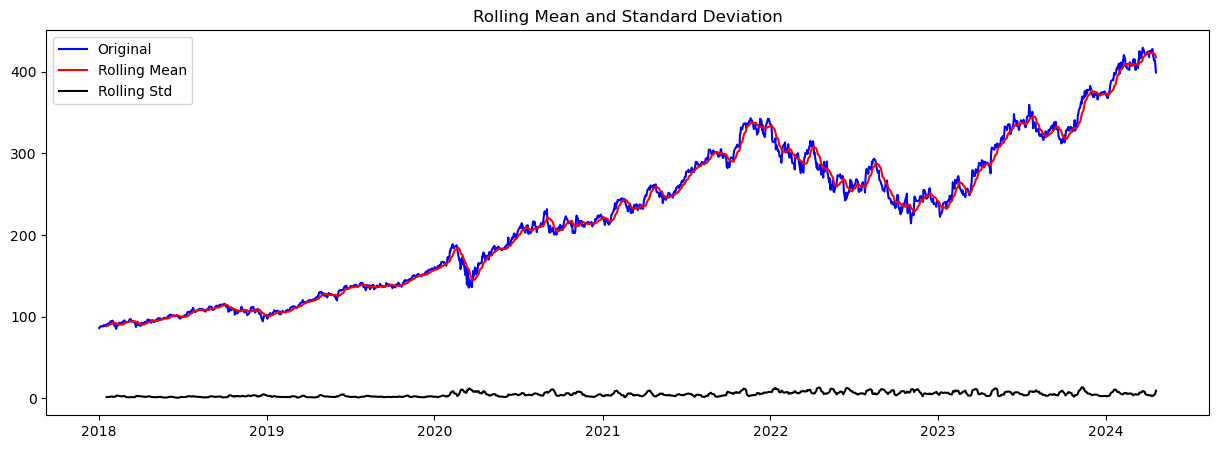

Results of dickey fuller test
Test Statistics                  -0.275405
p-value                           0.928916
No. of lags used                  9.000000
Number of observations used    1575.000000
dtype: float64


Hit Rate: 54.75%
Test RMSE: 4.808


In [45]:
def create_arima(df, ticker):
   # Split data into training and testing sets
   df_train = df[df.index < '2023-02-02']
   df_valid = df[df.index >= '2023-02-02']
   train = df_train['Close'].values
   test = df_valid['Close'].values

   # Find the optimal p,d,q
   model = auto_arima(train, start_p=0, start_q=0, test='adf', max_p=5, max_q=5,
                   m=1, d=None, seasonal=False,
                   start_P=0, D=0,
                   trace=False, error_action='ignore',
                   suppress_warnings=True, stepwise=True)
   
   p, d, q = model.order
   optimal_values = p,d,q
   history = [x for x in train]
   predictions = list()

   # Train the model using optimal p,d,q values
   for t in range(len(df_valid)):
      model = ARIMA(history, order=(optimal_values))
      model_fit = model.fit()
      output = model_fit.forecast()
      yhat = output[0]
      predictions.append(yhat)
      obs = test[t]
      history.append(obs)

   #Calculate accuracy of model
   rmse_arima = math.sqrt(mean_squared_error(test, predictions))
   threshold = 1
   actual_prices = df_valid['Close']
   percentage_changes = ((predictions - actual_prices) / actual_prices) * 100
   correct_predictions = np.sum(np.abs(percentage_changes) <= threshold)
   rate_ARIMA = (correct_predictions / len(actual_prices)) * 100

   # Display model results
   fig = go.Figure()
   fig.update_layout(xaxis_title="Date", yaxis_title="Stock Price ($)", title = f"Actual vs. Forecasted Closing Price of {ticker} (ARIMA)")
   fig.add_trace(go.Scatter(x=df_train.index,y=df_train.Close,name='Training Data'))
   fig.add_trace(go.Scatter(x=df_valid.index,y=df_valid.Close,name='Testing Data'))
   fig.add_trace(go.Scatter(x=df_valid.index,y=predictions,name='Forecasted Data'))
   fig.show()

   # Print accuracy rates of model
   print("Hit Rate: %.2f%%" % rate_ARIMA)
   print('Test RMSE: %.3f' % rmse_arima)

In [49]:
def create_lstm(df, ticker):
    # Splitting data into training and testing sets
    df_train = df[df.index < '2023-02-02']
    df_valid = df[df.index >= '2023-02-02']
    train_lstm = df_train['Close'].values
    test_lstm = df_valid['Close'].values

    # Pre-process data for LSTM model; Scaling and reshaping data
    scaler = MinMaxScaler(feature_range=(0,1))
    training_values = np.reshape(train_lstm,(len(train_lstm),1))
    training_values = scaler.fit_transform(training_values)

    # Assigning training values to the training data
    x_train = training_values[0:len(training_values)-1]
    y_train = training_values[1:len(training_values)]
    x_train = np.reshape(x_train,(len(x_train),1,1))

    # Creating, compiling, training the model
    model = Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(LSTM(50,return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(x_train,y_train,epochs=5,batch_size=8)

    # assign test and predicted values + reshaping + converting back from scaler
    test_values = np.reshape(test_lstm, (len(test_lstm), 1))
    test_values = scaler.transform(test_values)
    test_values = np.reshape(test_values, (len(test_values), 1, 1))
    predicted_price = model.predict(test_values)
    predicted_price = scaler.inverse_transform(predicted_price)
    predicted_price = np.squeeze(predicted_price)

    #Plotting the model results
    fig = go.Figure()
    fig.update_layout(xaxis_title="Date", yaxis_title="Stock Price ($)", title = f"Actual vs. Forecasted Closing Price of {ticker} (LSTM)")
    fig.add_trace(go.Scatter(x=df_train.index,y=df_train.Close,name='Training Data'))
    fig.add_trace(go.Scatter(x=df_valid.index,y=df_valid.Close,name='Testing Data'))
    fig.add_trace(go.Scatter(x=df_valid.index,y=predicted_price,name='Forecasted Data'))
    fig.show()

    # Caculating accuracy and displaying it
    rmse_lstm = math.sqrt(mean_squared_error(test_lstm, predicted_price))
    threshold = 1
    actual_prices = df_valid['Close']
    percentage_changes = ((predicted_price - actual_prices) / actual_prices) * 100
    correct_predictions = np.sum(np.abs(percentage_changes) <= threshold)
    rate_LSTM = (correct_predictions / len(actual_prices)) * 100
    print('Test MSE: %.3f' % rmse_lstm)
    print("Hit Rate: %.2f%%" % rate_LSTM)

tick = 'MSFT'
data = create_dataset(tick)
candlestick_chart(data, tick)
yearly_returns(data, tick)
test_stationarity(data['Close'])
create_arima(data, tick)
create_lstm(data, tick)

[*********************100%%**********************]  1 of 1 completed


Epoch 1/5
160/160 [==============================] - 4s 4ms/step - loss: 0.0372
Epoch 2/5
160/160 [==============================] - 1s 3ms/step - loss: 4.0560e-04
Epoch 3/5
160/160 [==============================] - 1s 3ms/step - loss: 3.7226e-04
Epoch 4/5
160/160 [==============================] - 0s 3ms/step - loss: 2.9908e-04
Epoch 5/5
10/10 [==============================] - 1s 2ms/step


Test MSE: 3.666
Hit Rate: 58.69%
